In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Optimizer
import matplotlib.pyplot as plt
import time
import keras.backend as K
import keras

# import the necessary packages
from pyimagesearch.minigooglenet import MiniGoogLeNet
from pyimagesearch.clr_callback import CyclicLR
from pyimagesearch import config
from pyimagesearch import learningratefinder
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
import cv2
import sys

# Problem 1 

### $\color{purple}{\text{question 1}}$
- Write the weight update equations for the five adaptive learning rate methods. Explain each term clearly. What are the hyper-parameters in each policy ? Explain how AdaDelta and Adam are different from RMSProp. 

##### $\color{purple}{\text{Adagrad}}$
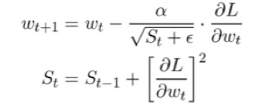
- Here the $\frac{\partial L}{\partial w_t}$, is the gradient for each update step, control this value by multiplying it with $\frac{1}{\sqrt{S_t+\epsilon}}$, will let actural learning rate become smaller and smaller, thus good for final covergence. So adagrad is a optimizer that decaying learning rate by $S_t$
- hyper-parameter:  
    - **base learning rate**: $\alpha$.  
    - $\epsilon$: none-zero denominator.
  

##### $\color{purple}{\text{RMSProp}}$
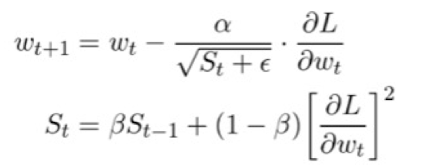
- RMSProp is very similar to Adagrad, they both controling learning rate by decaying it with multiplying it by $\frac{1}{\sqrt{S_t+\epsilon}}$, the difference is that RMSprop have additional hyper-parameter $\beta$ controling the decaying speed, if we let $\beta$ = 1, the learning rate will remain steady and don't change during learning.
- hyper-parameter:  
    - **base learning rate** : $\alpha$  
    - **decaying speed** : $\beta$  
    - $\epsilon$: none-zero denominator.

##### $\color{purple}{\text{RMSProp + Nesterov}}$
**Nesterov**  
$w_{t+1} = w_t - \frac{\alpha}{\sqrt{S_t + \epsilon}} V_t$  
$V_t = \beta_v V_{t_1} + (1- \beta_v)\frac{\partial L}{\partial w^*}$  
$S_t = \beta_d S_{t-1} + (1- \beta_d) [\frac{\partial L}{\partial w_t}]^2$   
$w^* = w_t - \alpha V_{t-1}$

- Very similar to RMSprop, adding Nesterov just introduces momentum and predicting next position instead of directly using velosity.
- Here we have to hyper-parameters combine **RMSprop** with **Nesterov**:
    - $\beta_v$ is a hyper-parameter controlling the gradient using momentum mechanism, if $\beta_v$ = 0, previous velocity will not affect following learning gradient.
    - $\beta_d$ is a hyper-parameter controlling the decaying in RMSprop, if we let $\beta_d$ = 1, the learning rate will remain steady and don't change during learning.
    - $\epsilon$: none-zero denominator.

##### $\color{purple}{\text{Adadelta}}$
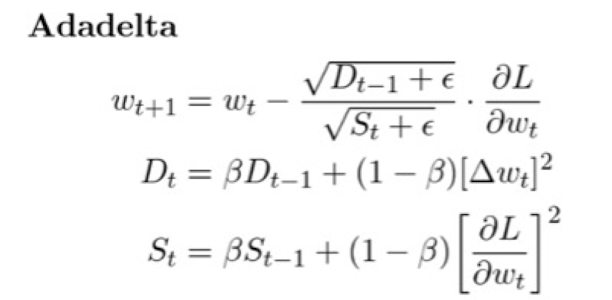
- As shown above, Adadelta has one hyper-parameters.
- In the denominator, it's the same learning rate decay as **RMSprop** and **Adagrad**, it controls the decaying speed of the learning rate.
- The nominator is different, Since Adagrad will finally reduce the learning rate to 0 as iteration increases, the nominator is actually an improvement of this weakness, so instead of traditional learning rate $\alpha$, here Adadelta uses the accumulation of changes of weight as the learning rate. So in the early stage, the gradient is huge, so the change of weights is huge, thus we get a larger $D_t$, and finally, when the network is close to convergence, the change of weights is small, thus we get a smaller $D_t$.

##### $\color{purple}{\text{Adam}}$
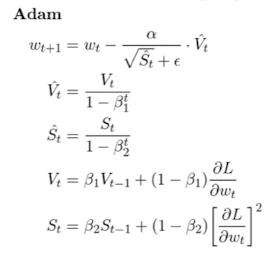
- Adam combine the decaying mechanism in RMSprop and momentum.
- Adam have three hyper-paramters:  
    - $\alpha$: base learning rate  
    - $\beta_1$: control the momentum. If $beta_1$ = 0, then previous velocity will not influence following gradients.
    - $\beta_2$: control the weight decay speed. If $\beta_2$ = 0, the weight decay will not accumulate.

##### $\color{purple}{\text{The difference between AdaDelta and Adam}}$
- Instead of using $\Delta w_t$ to control the learning rate, Adam uses momentum instead, and both Adadelta and Adam are using $S_t$ to control weight's scale.

### $\color{purple}{\text{question 2}}$
- Train the neural network using all the five methods with L2-regularization for 200 epochs each and plot the training loss vs number of epochs. Which method performs best (lowest training loss) ?

In [2]:
#load data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [3]:
def make_an_optimizer(optimizer_type):
    if optimizer_type == 'Adagrad':
        return tf.keras.optimizers.Adagrad()
    elif optimizer_type == 'Adadelta':
        return tf.keras.optimizers.Adadelta()
    elif optimizer_type == 'RMSprop':
        return tf.keras.optimizers.RMSprop()
    elif optimizer_type == 'RMSprop_nesterov':
        return tf.keras.optimizers.Nadam()
    elif optimizer_type == 'Adam':
        return tf.keras.optimizers.Adam()
    
def train_a_neural_network(regularization_type, optimizer_type, epoch, batch_size):
    # define model
    if regularization_type == "L2_regularization":
        model = keras.models.Sequential([
            Flatten( input_shape = (32,32,3)),
            Dense(1000, activation = 'relu', kernel_regularizer='l2', kernel_initializer='HeNormal'),
            Dense(1000, activation = 'relu', kernel_regularizer='l2', kernel_initializer='HeNormal'),
            Dense(10, activation = 'softmax')
        ])
    if regularization_type == "drop_out":
        model = keras.models.Sequential([
            Flatten( input_shape = (32,32,3)),
            Dropout(0.2),
            Dense(1000, activation = 'relu', kernel_initializer='HeNormal'),
            Dropout(0.5),
            Dense(1000, activation = 'relu', kernel_initializer='HeNormal'),
            Dropout(0.5),
            Dense(10, activation = 'softmax')
        ])
    optimizer = make_an_optimizer(optimizer_type)
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    time_start = time.time()
    history = model.fit(x_train, y_train, epochs = epoch, batch_size = batch_size,
                        validation_data=(x_test, y_test), verbose = 0)
    time_end = time.time()
    return model, history, time_end - time_start
optimizer_lost = ['Adagrad', 'Adadelta', 'RMSprop', 'RMSprop_nesterov', 'Adam']

In [4]:
model_2_1, history_2_1, time_2_1 = train_a_neural_network('L2_regularization', optimizer_lost[0], 200, 128)

In [5]:
model_2_2, history_2_2, time_2_2 = train_a_neural_network('L2_regularization', optimizer_lost[1], 200, 128)

In [6]:
model_2_3, history_2_3, time_2_3 = train_a_neural_network('L2_regularization', optimizer_lost[2], 200, 128)

In [7]:
model_2_4, history_2_4, time_2_4 = train_a_neural_network('L2_regularization', optimizer_lost[3], 200, 128)

In [8]:
model_2_5, history_2_5, time_2_5 = train_a_neural_network('L2_regularization', optimizer_lost[4], 200, 128)

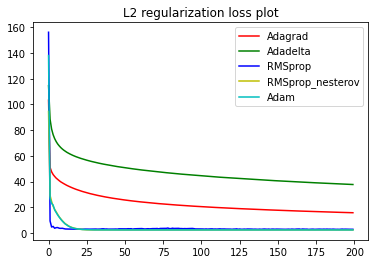

In [10]:
#LOSS PLOT
epoch_vis = list(range(len(history_2_1.history['loss'])))
plt.plot(epoch_vis,history_2_1.history['loss'], label = optimizer_lost[0], c = 'r')
plt.plot(epoch_vis,history_2_2.history['loss'], label = optimizer_lost[1], c = 'g')
plt.plot(epoch_vis,history_2_3.history['loss'], label = optimizer_lost[2], c = 'b')
plt.plot(epoch_vis,history_2_4.history['loss'], label = optimizer_lost[3], c = 'y')
plt.plot(epoch_vis,history_2_5.history['loss'], label = optimizer_lost[4], c = 'c')
plt.legend()
plt.title('L2 regularization loss plot')
plt.show()

In [21]:
(history_2_1.history['loss'][-1],
history_2_2.history['loss'][-1],
history_2_3.history['loss'][-1],
history_2_4.history['loss'][-1],
history_2_5.history['loss'][-1])

(15.68968391418457,
 37.67438888549805,
 2.7793161869049072,
 2.302692413330078,
 2.302698850631714)

- Compared with other optimizers, RMSprop, Adam and RMSprop+nesterov have the lowest loss. Adagrad and Adadelta have a higher loss.
- RMSprop_nesterov's loss is 2.302692413330078 is the lowest loss.

### $\color{purple}{\text{question 3}}$
- Add dropout (probability 0.2 for input layer and 0.5 for hidden layers) and train the neural network again using all the five methods for 200 epochs. Compare the training loss with that in part 2. Which method performs the best ? For the five methods, compare their training time (to finish 200 epochs with dropout) to the training time in part 2 (to finish 200 epochs without dropout).

In [11]:
model_3_1, history_3_1, time_3_1 = train_a_neural_network('drop_out', optimizer_lost[0], 200, 128)

In [12]:
model_3_2, history_3_2, time_3_2 = train_a_neural_network('drop_out', optimizer_lost[1], 200, 128)

In [13]:
model_3_3, history_3_3, time_3_3 = train_a_neural_network('drop_out', optimizer_lost[2], 200, 128)

In [14]:
model_3_4, history_3_4, time_3_4 = train_a_neural_network('drop_out', optimizer_lost[3], 200, 128)

In [15]:
model_3_5, history_3_5, time_3_5 = train_a_neural_network('drop_out', optimizer_lost[4], 200, 128)

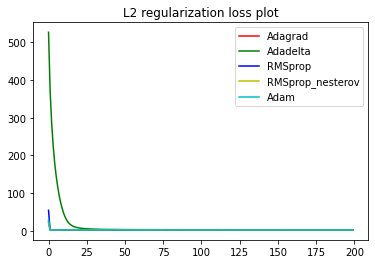

In [16]:
#LOSS PLOT
epoch_vis = list(range(len(history_2_1.history['loss'])))
plt.plot(epoch_vis,history_3_1.history['loss'], label = optimizer_lost[0], c = 'r')
plt.plot(epoch_vis,history_3_2.history['loss'], label = optimizer_lost[1], c = 'g')
plt.plot(epoch_vis,history_3_3.history['loss'], label = optimizer_lost[2], c = 'b')
plt.plot(epoch_vis,history_3_4.history['loss'], label = optimizer_lost[3], c = 'y')
plt.plot(epoch_vis,history_3_5.history['loss'], label = optimizer_lost[4], c = 'c')
plt.legend()
plt.title('L2 regularization loss plot')
plt.show()

In [20]:
(history_3_1.history['loss'][-1],
history_3_2.history['loss'][-1],
history_3_3.history['loss'][-1],
history_3_4.history['loss'][-1],
history_3_5.history['loss'][-1])

(2.3035354614257812,
 2.4348690509796143,
 2.3067286014556885,
 2.302696943283081,
 2.3027024269104004)

In [22]:
# time difference between part 2 and part 3
(time_2_1 - time_3_1, time_2_2 - time_3_2, time_2_3 - time_3_3, time_2_4 - time_3_4, time_2_5 - time_3_5 )

(22.345446825027466,
 26.96778964996338,
 23.584877967834473,
 24.263986825942993,
 26.715335607528687)

- After adding dropout, all 5 optimizers decrease loss to similar level, and the oen with the lowest loss is RMSprop with nesterov.
- After adding dropout, the training is much faster, around 25 seconds faster than L2 regularization.

### $\color{purple}{\text{question 4}}$

In [32]:
print('test accuracy for 10 models: ')
(history_2_1.history['val_accuracy'][-1],
history_2_2.history['val_accuracy'][-1],
history_2_3.history['val_accuracy'][-1],
history_2_4.history['val_accuracy'][-1],
history_2_5.history['val_accuracy'][-1],
history_3_1.history['val_accuracy'][-1],
history_3_2.history['val_accuracy'][-1],
history_3_3.history['val_accuracy'][-1],
history_3_4.history['val_accuracy'][-1],
history_3_5.history['val_accuracy'][-1])

test accuracy for 10 models: 


(0.4440000057220459,
 0.37059998512268066,
 0.20630000531673431,
 0.10000000149011612,
 0.10000000149011612,
 0.09989999979734421,
 0.10019999742507935,
 0.10000000149011612,
 0.10000000149011612,
 0.10000000149011612)

- According to the result, adding dropout can let loss decrease loss at start, but can't let model converge. All models with dropout finally have test accuracy around 0.1(random guess). (maybe need to fine tune the learning rate for dropout for a better performance).
- The best model is L2 regularization with Adagrad optimizer, which has test accuracy around 44%.

# problem 2

### $\color{purple}{\text{question 1}}$
- Fix batch size to 64 and start with 10 candidate learning rates between $10^{-9}$ and $10^1$ and train your model for 5 epochs. Plot the training loss as a function of learning rate. You should see a curve like Figure 3 in reference below. From that figure identify the values of $lr_{min}$ and $lr_{max}$.

In [2]:
# prepare data
img_witdth, img_height = 32, 32
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()

trainX = trainX.astype("float")
testX = testX.astype("float")
# apply mean subtraction to the data
mean = np.mean(trainX, axis=0)
trainX -= mean
testX -= mean

# Fashion MNIST images are 28x28 but the network we will be training
# is expecting 32x32 images
trainX = np.array([cv2.resize(x, (img_witdth, img_height)) for x in trainX])
testX = np.array([cv2.resize(x, (img_witdth, img_height)) for x in testX])

# scale the pixel intensities to the range [0, 1]
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0


# reshape the data matrices to include a channel dimension (required
# for training)

trainX = trainX.reshape((trainX.shape[0], img_witdth, img_height, 1))
testX = testX.reshape((testX.shape[0], img_witdth, img_height, 1))


# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# construct the image generator for data augmentation
aug = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
)

In [49]:
min_lr = 1e-9
max_lr = 10
opt = SGD(min_lr, momentum=0.9)
model = MiniGoogLeNet.build(width=img_witdth, height=img_height, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
clr = CyclicLR(
    mode=config.CLR_METHOD,
    base_lr=min_lr,
    max_lr=max_lr,
    step_size=config.STEP_SIZE * (trainX.shape[0] // config.BATCH_SIZE),
)
H = model.fit(
    x=aug.flow(trainX, trainY, batch_size=config.BATCH_SIZE),
    validation_data=(testX, testY),
    steps_per_epoch=trainX.shape[0] // config.BATCH_SIZE,
    epochs=config.NUM_EPOCHS,
    callbacks=[clr],
    verbose=1,
)

Epoch 1/5
937/937 [==============================] - 26s 26ms/step - loss: 0.7838 - accuracy: 0.7200 - val_loss: 4.4435 - val_accuracy: 0.6254
Epoch 2/5
937/937 [==============================] - 25s 26ms/step - loss: 0.7418 - accuracy: 0.7511 - val_loss: 8.0529 - val_accuracy: 0.5188
Epoch 3/5
937/937 [==============================] - 25s 26ms/step - loss: 0.8490 - accuracy: 0.7135 - val_loss: 12.0776 - val_accuracy: 0.4553
Epoch 4/5
937/937 [==============================] - 25s 26ms/step - loss: 1.8450 - accuracy: 0.4219 - val_loss: 19.7525 - val_accuracy: 0.0990
Epoch 5/5
937/937 [==============================] - 24s 26ms/step - loss: 2.5047 - accuracy: 0.1058 - val_loss: 3.0525 - val_accuracy: 0.1000


Epoch 1/20
938/938 [==============================] - 23s 24ms/step - loss: 12.5062 - accuracy: 0.1000
Epoch 2/20
938/938 [==============================] - 23s 24ms/step - loss: 12.5069 - accuracy: 0.1000
Epoch 3/20
938/938 [==============================] - 23s 24ms/step - loss: 12.5069 - accuracy: 0.1000
Epoch 4/20
938/938 [==============================] - 23s 24ms/step - loss: 12.5067 - accuracy: 0.1000
Epoch 5/20
938/938 [==============================] - 23s 24ms/step - loss: 12.5058 - accuracy: 0.1000
Epoch 6/20
938/938 [==============================] - 23s 24ms/step - loss: 12.5030 - accuracy: 0.1000
Epoch 7/20
938/938 [==============================] - 23s 24ms/step - loss: 12.4938 - accuracy: 0.1000
Epoch 8/20
938/938 [==============================] - 23s 24ms/step - loss: 12.4649 - accuracy: 0.1000
Epoch 9/20
938/938 [==============================] - 23s 24ms/step - loss: 12.3736 - accuracy: 0.1000
Epoch 10/20
938/938 [==============================] - 23s 24ms/step - lo

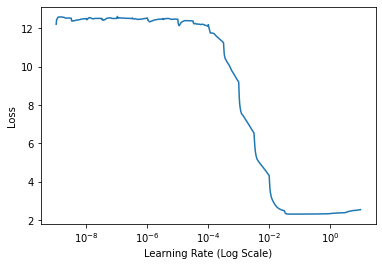

In [61]:
lrf = learningratefinder.LearningRateFinder(model)
lrf.find(
    aug.flow(trainX, trainY, batch_size=config.BATCH_SIZE),
    min_lr,
    max_lr,
    stepsPerEpoch=np.ceil((len(trainX) / float(config.BATCH_SIZE))),
    batchSize=config.BATCH_SIZE, 
epochs = 20)
lrf.plot_loss()

### $\color{purple}{\text{question 2}}$
Use the cyclical learning rate policy (with exponential decay) and train your network using batch size 64 and lrmin and lrmax values obtained in part 1. Here you will train till convergence and not just 5 epochs as in part 1. Plot train/validation loss and accuracy curve (similar to Figure 4 in reference)

- According to previous findings, the min max learning rate is around ($10^{-4}$, $10^{-1}$)

In [70]:
min_lr = 10e-4
max_lr = 10e-1
# Set learning rate to the best one find in question 1
opt = SGD(lr = min_lr, momentum=0.9)
clr = CyclicLR(
    mode='exp_range',
    base_lr=min_lr,
    max_lr=min_lr,
    step_size=config.STEP_SIZE * (trainX.shape[0] // config.BATCH_SIZE),
)
lr = lrf.lrs[lrf.losses.index(min(lrf.losses))]
model = MiniGoogLeNet.build(width=img_witdth, height=img_height, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
H = model.fit(
    x=aug.flow(trainX, trainY, batch_size=config.BATCH_SIZE),
    validation_data=(testX, testY),
    steps_per_epoch=trainX.shape[0] // config.BATCH_SIZE,
    epochs=20,
    callbacks=[clr],
    verbose=1
)

Epoch 1/20
937/937 [==============================] - 27s 27ms/step - loss: 0.9066 - accuracy: 0.6744 - val_loss: 0.6254 - val_accuracy: 0.7699
Epoch 2/20
937/937 [==============================] - 25s 27ms/step - loss: 0.5789 - accuracy: 0.7870 - val_loss: 0.5014 - val_accuracy: 0.8134
Epoch 3/20
937/937 [==============================] - 25s 26ms/step - loss: 0.4935 - accuracy: 0.8200 - val_loss: 0.5241 - val_accuracy: 0.8077
Epoch 4/20
937/937 [==============================] - 25s 26ms/step - loss: 0.4432 - accuracy: 0.8391 - val_loss: 0.4313 - val_accuracy: 0.8458
Epoch 5/20
937/937 [==============================] - 25s 27ms/step - loss: 0.4081 - accuracy: 0.8520 - val_loss: 0.3967 - val_accuracy: 0.8566
Epoch 6/20
937/937 [==============================] - 25s 26ms/step - loss: 0.3795 - accuracy: 0.8629 - val_loss: 0.4190 - val_accuracy: 0.8448
Epoch 7/20
937/937 [==============================] - 25s 27ms/step - loss: 0.3580 - accuracy: 0.8702 - val_loss: 0.3538 - val_accuracy:

In [71]:
# model is still not converged, train 20 more epochs
H_1 = model.fit(
    x=aug.flow(trainX, trainY, batch_size=config.BATCH_SIZE),
    validation_data=(testX, testY),
    steps_per_epoch=trainX.shape[0] // config.BATCH_SIZE,
    epochs=20,
    callbacks=[clr],
    verbose=1
)

Epoch 1/20
937/937 [==============================] - 25s 26ms/step - loss: 0.2399 - accuracy: 0.9138 - val_loss: 0.3322 - val_accuracy: 0.8843
Epoch 2/20
937/937 [==============================] - 25s 27ms/step - loss: 0.2381 - accuracy: 0.9147 - val_loss: 0.2595 - val_accuracy: 0.9083
Epoch 3/20
937/937 [==============================] - 25s 26ms/step - loss: 0.2305 - accuracy: 0.9179 - val_loss: 0.2787 - val_accuracy: 0.9037
Epoch 4/20
937/937 [==============================] - 25s 26ms/step - loss: 0.2285 - accuracy: 0.9177 - val_loss: 0.2677 - val_accuracy: 0.9034
Epoch 5/20
937/937 [==============================] - 25s 27ms/step - loss: 0.2227 - accuracy: 0.9207 - val_loss: 0.2897 - val_accuracy: 0.8949
Epoch 6/20
937/937 [==============================] - 25s 27ms/step - loss: 0.2227 - accuracy: 0.9201 - val_loss: 0.2844 - val_accuracy: 0.8924
Epoch 7/20
937/937 [==============================] - 25s 27ms/step - loss: 0.2183 - accuracy: 0.9208 - val_loss: 0.2611 - val_accuracy:

In [72]:
# still not converged, train 20 more epochs
# model is still not converged, train 20 more epochs
H_2 = model.fit(
    x=aug.flow(trainX, trainY, batch_size=config.BATCH_SIZE),
    validation_data=(testX, testY),
    steps_per_epoch=trainX.shape[0] // config.BATCH_SIZE,
    epochs=20,
    callbacks=[clr],
    verbose=1
)

Epoch 1/20
937/937 [==============================] - 25s 26ms/step - loss: 0.1754 - accuracy: 0.9372 - val_loss: 0.2347 - val_accuracy: 0.9150
Epoch 2/20
937/937 [==============================] - 25s 26ms/step - loss: 0.1733 - accuracy: 0.9375 - val_loss: 0.2208 - val_accuracy: 0.9224
Epoch 3/20
937/937 [==============================] - 25s 26ms/step - loss: 0.1731 - accuracy: 0.9375 - val_loss: 0.2472 - val_accuracy: 0.9122
Epoch 4/20
937/937 [==============================] - 25s 26ms/step - loss: 0.1698 - accuracy: 0.9381 - val_loss: 0.2355 - val_accuracy: 0.9167
Epoch 5/20
937/937 [==============================] - 25s 26ms/step - loss: 0.1679 - accuracy: 0.9394 - val_loss: 0.2374 - val_accuracy: 0.9167
Epoch 6/20
937/937 [==============================] - 25s 26ms/step - loss: 0.1648 - accuracy: 0.9404 - val_loss: 0.2243 - val_accuracy: 0.9217
Epoch 7/20
937/937 [==============================] - 25s 26ms/step - loss: 0.1597 - accuracy: 0.9420 - val_loss: 0.2337 - val_accuracy:

- utill 60 epochs, although the training loss is still decreasing, the test accuracy is steady, so I think 60 epochs is enough for the training.

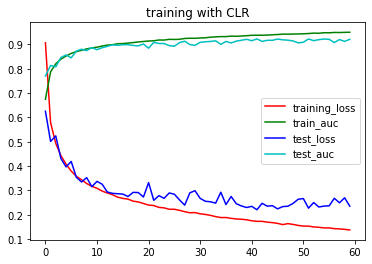

In [77]:
epochs_vis = list(range(60))
train_loss = np.concatenate([H.history['loss'], H_1.history['loss'], H_2.history['loss']],axis = 0)
train_auc = np.concatenate([H.history['accuracy'], H_1.history['accuracy'], H_2.history['accuracy']],axis = 0)
test_loss = np.concatenate([H.history['val_loss'], H_1.history['val_loss'], H_2.history['val_loss']],axis = 0)
test_auc = np.concatenate([H.history['val_accuracy'], H_1.history['val_accuracy'], H_2.history['val_accuracy']],axis = 0)
plt.plot(epochs_vis, train_loss, label = 'training_loss', c = 'r')
plt.plot(epochs_vis, train_auc, label = 'train_auc', c = 'g')
plt.plot(epochs_vis, test_loss, label = 'test_loss', c = 'b')
plt.plot(epochs_vis, test_auc, label = 'test_auc', c = 'c')
plt.legend()
plt.title('training with CLR')
plt.show()

### $\color{purple}{\text{question 3}}$
We want to test if increasing batch size for a fixed learning rate has the same effect as decreasing learning rate for a fixed batch size. Fix learning rate to lrmax and train your network starting with batch size 32 and incrementally going upto 16384 (in increments of a factor of 2; like 32, 64...). You can choose a step size (in terms of number of iterations) to increment the batch size. If your GPU cannot handle large batch sizes, you need to employ effective batch size approach as discussed in Lecture 3 to simulate large batches. Plot the training loss as a function of batch size. Is the generalization of your final model similar or different than cyclical learning rate policy?

In [3]:
def run_batch_experiment(batch_size, num_epochs):
    all_loss = []
    optimizer = SGD(learning_rate=0.1, momentum=0.9)
    model = MiniGoogLeNet.build(width=img_witdth, height=img_height, depth=1, classes=10)
    batch_size = batch_size
    train_dataset = tf.data.Dataset.from_tensor_slices((trainX, trainY))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
    epochs = num_epochs
    for epoch in range(epochs):
        print('current working epoch:' + str(epoch), end='\r')
        if batch_size<=512:
            for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                print('current working epoch:'+ str(epoch)+ '   current working batch:' + str(step) + '/'+str(len(train_dataset)),
                      flush=True,end='\r')
                with tf.GradientTape() as tape:
                    logits = model(x_batch_train, training=True)  # Logits for this minibatch
                    loss_value = keras.losses.categorical_crossentropy(y_batch_train, logits)
                grads = tape.gradient(loss_value, model.trainable_weights)
                final_grad = []
                for grad_layer in grads:
                    final_grad.append(grad_layer/batch_size)
                optimizer.apply_gradients(zip(final_grad, model.trainable_weights))
                all_loss.append(loss_value)
        else:
            for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                print('current working epoch:'+ str(epoch)+ '   current working batch:' + str(step) + '/'+str(len(train_dataset)),
                      flush=True,end='\r')
                start = 0
                end = 512
                grads_list = []
                loss_list_this_micro_batch = []
                for i in range(int(batch_size/512)):
                    if start+512 > x_batch_train.shape[0]:
                        batch_x = x_batch_train[start:,:,:,:]
                        batch_y = y_batch_train[start:,:]
                    else:
                        batch_x = x_batch_train[start:end,:,:,:]
                        batch_y = y_batch_train[start:end,:]
                    if batch_x.shape[0] > 0:
                        with tf.GradientTape() as tape:
                            logits = model(batch_x, training=True)  # Logits for this minibatch
                            loss_value = keras.losses.categorical_crossentropy(batch_y, logits)
                        grads = tape.gradient(loss_value, model.trainable_weights)  
                        grads_list.append(grads)
                        loss_list_this_micro_batch.append(loss_value)
                        start += 512
                        end += 512
                    else:
                        pass
                # calculate mean grads for each layer
                final_layer_grads = []
                loss_list_this_micro_batch = np.concatenate(loss_list_this_micro_batch,axis = 0)
                all_loss.append(loss_list_this_micro_batch)
                for layer_index in range(len(grads_list[0])):
                    grads_this_layer = []
                    for micro_batch_index in range(len(grads_list)):
                        grads_this_layer.append(grads_list[micro_batch_index][layer_index])
                    final_layer_grads.append(sum(grads_this_layer)/((len(grads_list)*512)))
                optimizer.apply_gradients(zip(final_layer_grads, model.trainable_weights))
    return all_loss

In [4]:
loss_32 = run_batch_experiment(32,10)

In [5]:
loss_64 = run_batch_experiment(64,10)

In [6]:
loss_128 = run_batch_experiment(128,10)

In [7]:
loss_256 = run_batch_experiment(256,10)

In [8]:
loss_512 = run_batch_experiment(512,10)

In [9]:
loss_1024 = run_batch_experiment(1024,10)

In [10]:
loss_2048 = run_batch_experiment(2048,10)

In [11]:
loss_4096 = run_batch_experiment(4096,10)

In [12]:
loss_8192 = run_batch_experiment(8192,10)

In [13]:
loss_16384 = run_batch_experiment(16384,10)

In [40]:
losses = [loss_32,loss_64,loss_128,loss_256,loss_512,loss_1024,loss_2048,loss_4096,loss_8192,loss_16384]
losses_mean = []
for i in losses:
    losses_mean.append(np.mean(i[-1]))

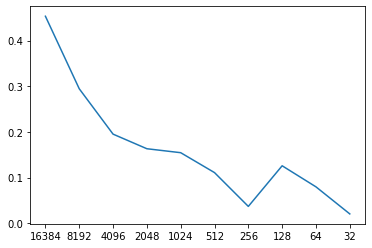

In [41]:
vis_x = ['32','64','128','256','512','1024','2048','4096','8192','16384']
vis_x.reverse()
losses_mean.reverse()
plt.plot(vis_x,losses_mean)

- From the plot we can see.
    - Large learning rate = small batch size => having lower training loss 
    - We see a similar curve as CLR algorithm

# Problem 3

### $\color{purple}{\text{question 1}}$
Calculate the number of parameters in Alexnet. You will have to show calculations for each layer and then sum it to obtain the total number of parameters in Alexnet. When calculating you will need to account for all the filters (size, strides, padding) at each layer. Look at Sec. 3.5 and Figure 2 in Alexnet paper (see reference). Points will only be given when explicit calculations are shown for each layer. 

conv1: $(11\times11)\times3\times96 + 96 = 34944$

conv2: $(5\times5) \times96 \times256 + 256 = 614656$

conv3: $(3 \times3) \times256 \times384 + 384 = 885120$

conv4: $(3 \times3) \times384 \times384 + 384 = 1327488$

conv5: $(3 \times3) \times384 \times256 + 256 = 884992$

fc1: $(6 \times6) \times256 \times4096 + 4096 = 37752832$

fc2: $4096 \times4096 + 4096 = 16781312$

fc3: $4096 \times1000 + 1000 = 4097000$

total_parameters: conv1+conv2+conv3+conv4+conv5+fc1+fc2+fc3 = $62378344$

### $\color{purple}{\text{question 2}}$
VGG (Simonyan et al.) has an extremely homogeneous architecture that only performs 3x3 convolutions with stride 1 and pad 1 and 2x2 max pooling with stride 2 (and no padding) from the beginning to the end. However VGGNet is very expensive to evaluate and uses a lot more memory and parameters. Refer to VGG19 architecture on page 3 in Table 1 of the paper by Simonyan et al. You need to complete Table 1 below for calculating activation units and parameters at each layer in VGG19 (without counting biases). Its been partially filled for you.

In [28]:
col_1 = ['input', 'Conv3-64', 'Conv3-64', 'POOL2',
         'CONV3-128','CONV3-128','POOL2',
         'CONV3-256','CONV3-256','CONV3-256','CONV3-256','POOL2',
        'CONV3-512','CONV3-512','CONV3-512','CONV3-512','POOL2',
        'CONV3-512','CONV3-512','CONV3-512','CONV3-512','POOL2',
        'FC','FC','FC','TOTAL']
col_2 = ['224*224*3 = 150K','224*224*64 = 3.2M','224*224*64 = 3.2M','112*112*64 = 800K',
        '112*112*128 = 1.6M','112*112*128 = 1.6M','56*56*128 = 400K',
        '56*56*256 = 800K','56*56*256 = 800K','56*56*256 = 800K','56*56*256 = 800K','28*28*256 = 200K',
        '28*28*512 = 400K','28*28*512 = 400K','28*28*512 = 400K','28*28*512 = 400K','14*14*512 = 100K',
        '14*14*512 = 100K','14*14*512 = 100K','14*14*512 = 100K','14*14*512 = 100K','7*7*512 = 25K',
        '4096','4096','1000','sum(all)']
col_3 = ['0', '(3*3*3)*64=1728', '(3*3*64)*64 = 36864', '0',
         '(3*3*64)*128 = 73728','(3*3*128)*128 = 147456','0',
         '(3*3*128)*256 = 294912','(3*3*256)*256 = 589824','(3*3*256)*256 = 589824','(3*3*256)*256 = 589824','0',
        '(3*3*256)*512 = 117948','(3*3*512)*512 = 2358296','(3*3*512)*512 = 2358296','(3*3*512)*512 = 2358296','0',
        '(3*3*512)*512 = 2358296','(3*3*512)*512 = 2358296','(3*3*512)*512 = 2358296','(3*3*512)*512 = 2358296','0',
        '7*7*512*4096','4096*4096','4096*1000','sum(all)']
table = pd.DataFrame([col_1, col_2, col_3]).transpose()
table.rename({0:'Layer',1:'Number of Activations (Memory)',2:'Parameters(Compute)'}, axis = 1)

,Layer,Number of Activations (Memory),Parameters(Compute)
0,input,224*224*3 = 150K,0
1,Conv3-64,224*224*64 = 3.2M,(3*3*3)*64=1728
2,Conv3-64,224*224*64 = 3.2M,(3*3*64)*64 = 36864
3,POOL2,112*112*64 = 800K,0
4,CONV3-128,112*112*128 = 1.6M,(3*3*64)*128 = 73728
5,CONV3-128,112*112*128 = 1.6M,(3*3*128)*128 = 147456
6,POOL2,56*56*128 = 400K,0
7,CONV3-256,56*56*256 = 800K,(3*3*128)*256 = 294912
8,CONV3-256,56*56*256 = 800K,(3*3*256)*256 = 589824
9,CONV3-256,56*56*256 = 800K,(3*3*256)*256 = 589824


### $\color{purple}{\text{question 3}}$
VGG architectures have smaller filters but deeper networks compared to Alexnet (3x3 compared to 11x11 or 5x5). Show that a stack of N convolution layers each of filter size F ×F has the same receptive field as one convolution layer with filter of size (N F −N + 1) ×(N F −N + 1). Use this to calculate the receptive field of 3 filters of size 5x5.

- $N_{th}$ output size: 1*1, input_size = (1+F-1) * (1+F-1)
- $N-1_{th}$ output size: (1+F-1) * (1+F-1), input_size = (1+2F-2)(1+2F-2)
- $N-2_{th}$ output size: (1+2F-2)(1+2F-2), input_size = (1+3F-3)(1+3F-3)
- ......
- ......
- $input\_layer$: input_size = (1+NF-N)(1+NF-N)

- **Receptive field of 3 filters of size 5x5**:
    - $3_{rd}\ \ Filter$: output size = 1*1, input size = (1+5-1)(1+5-1) 
    - $2_{nd}\ \ Filter$: output size = (1+5-1)(1+5-1) , input size = (1+10-2)(1+10-2) 
    - $1_{st}\ \ Filter$: output size = (1+10-2)(1+10-2) , input size = (1+15-3)(1+15-3)  
    - receptice field is (1+15-3)(1+15-3) = 13*13

### $\color{purple}{\text{question 4}}$
The original Googlenet paper (Szegedy et al.) proposes two architectures for Inception module, shown in Figure 2 on page 5 of the paper, referred to as naive and dimensionality reduction respectively.

##### $\color{purple}{\text{(a)}}$
What is the general idea behind designing an inception module (parallel convolutional filters of different sizes with a pooling followed by concatenation) in a convolutional neural network ?
- By using different size of filters on the same activation maps and then concatenate them togather will provide model the ability to capture fine grind features as well as coarse grind features, by using the combined features will improve final model performance.

##### $\color{purple}{\text{(b)}}$
Assuming the input to inception module (referred to as ”previous layer” in Figure 2 of the paper) has size 32x32x256, calculate the output size after filter concatenation for the naive and dimensionality reduction inception architectures with number of filters given in Figure 1.
- (Naive version): 
    - input: $32*32*256$
    - $1*1$ conv output: $32*32*128$
    - $3*3$ conv output: $32*32*192$
    - $5*5$ conv output: $32*32*96$
    - $3*3$ maxpooling output: $32*32*256$
    - concatenate: $32*32*672$
- (dimension reduction version): 
    - input: $32*32*256$
    - $1*1$ conv output: $32*32*128$
    - $1*1 + 3*3$ conv output: $32*32*192$
    - $1*1 + 5*5$ conv output: $32*32*96$
    - $3*3 + 1*1$ pooling * conv: $32*32*64$
    - concatenate: $32*32*480$

##### $\color{purple}{\text{(c)}}$
Next calculate the total number of convolutional operations for each of the two inception architecture again assuming the input to the module has dimensions 32x32x256 and number of filters given in Figure 1.

- (Naive version): 
    - $1*1$ conv op: $32*32*128*1*1*256 = 33554432$
    - $3*3$ conv op: $32*32*192*3*3*256 = 452984832$
    - $5*5$ conv op: $32*32*96*5*5*256 = 629145600$
    - total ops: 1115684864

- (dimension reduction version): 
    - $1*1*64$ conv op: $32*32*64*1*1*256*3 = 50331648$
    - $1*1*128$ conv op: $32*32*128*1*1*256 = 33554432$ 
    - $3*3$ conv op: $32*32*192*3*3*64 = 113246208$
    - $5*5$ conv op: $32*32*96*5*5*64 = 157286400$
    - total ops: 354418688
    
##### $\color{purple}{\text{(d)}}$
Based on the calculations in part (c) explain the problem with naive architecture and how dimensionality reduction architecture helps (Hint: compare computational complexity). How much is the computational saving ? 
- Problem of naive architecture:  naive architecture need too many operations (need 1115684864 ops), training can be very computional intense.
- Dimensionality reduction first use $1*1$ conv layers to reduce the input channel from 256 to 64, and do $3*3$ and $5*5$ conv layers on the 64 channel input instead the total of 256 channels, thus greatly reduced computational complexity.
- Total saved ops: $1115684864 - 354418688 = 761266176$

# Problem 4

In [6]:
def apply_mask(image, size=12, n_squares=1):
    h, w, channels = image.shape
    new_image = image
    for _ in range(n_squares):
        y = np.random.randint(h)
        x = np.random.randint(w)
        y1 = np.clip(y - size // 2, 0, h)
        y2 = np.clip(y + size // 2, 0, h)
        x1 = np.clip(x - size // 2, 0, w)
        x2 = np.clip(x + size // 2, 0, w)
        new_image[y1:y2,x1:x2,:] = 0
    return new_image

### $\color{purple}{\text{question 1}}$
Explain cutout regularization and its advantages compared to simple dropout (as argued in the paper by DeVries et al) in your own words. Select any 2 images from CIFAR10 and show how does these images look after applying cutout. Use a square-shaped fixed size zero-mask to a random location of each image and generate its cutout version. Refer to the paper by DeVries et al (Section 3) and associated github repository.

- As stated in the paper, traditional drop out works fine for fully connected model,but it's less powerful for training a convlutional model. Two main reason for this is: 1, Conv layers have fewer parameters than fully-connected, thus require less regularization. 2, Input of conv layers is images, images have positional factor, information dropped can be repersented by near pixles, thus drop out algorithm is less effective in reducing co-adaptation.

In [2]:
from keras.datasets import cifar10
import tensorflow
#import dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

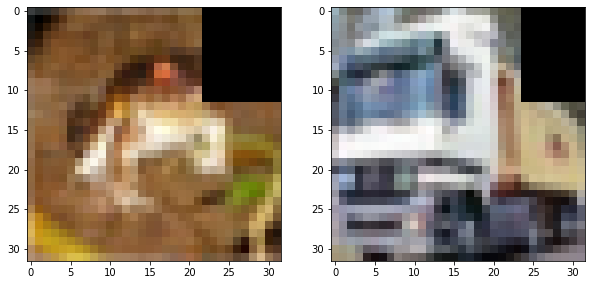

In [106]:
fig, ax = plt.subplots(1,2,figsize = (10,5))
ax[0].imshow(apply_mask(X_train[0].copy()))
ax[1].imshow(apply_mask(X_train[1].copy()))

### $\color{purple}{\text{question 2}}$
Using CIFAR10 datasest and Resnet-44 we will first apply simple data augmentation as in He et al. (look at Section 4.2 of He et al.) and train the model with batch size 64. Note that testing is always done with original images. Plot validation error vs number of training epochs.

In [3]:
'''
ResNet-44 code from 
https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py
'''

n = 7
depth = n * 6 + 2
input_shape = X_train[0].shape

def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    Arguments:
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    Returns:
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved
    (downsampled) by a convolutional layer with strides=2, while 
    the number of filters is doubled. Within each stage, 
    the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    Arguments:
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    Returns:
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, in [a])')
    # start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            # first layer but not first stack
            if stack > 0 and res_block == 0:
                # linear projection residual shortcut
                # connection to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


model = resnet_v1(input_shape=input_shape, depth=depth)

    

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['acc'])

C:\Learning\SoftWare\anaconda\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [87]:
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [lr_reducer, lr_scheduler]

history_nocutoff = model.fit(X_train, y_train,
              batch_size=64,
              epochs=100,
              validation_data=(X_test, y_test),
              shuffle=True,
              callbacks=callbacks)

Learning rate:  0.001
Epoch 1/100
782/782 [==============================] - 27s 29ms/step - loss: 1.7550 - acc: 0.4888 - val_loss: 1.6173 - val_acc: 0.5398 - lr: 0.0010
Learning rate:  0.001
Epoch 2/100
782/782 [==============================] - 22s 28ms/step - loss: 1.2806 - acc: 0.6535 - val_loss: 1.3426 - val_acc: 0.6387 - lr: 0.0010
Learning rate:  0.001
Epoch 3/100
782/782 [==============================] - 22s 28ms/step - loss: 1.0666 - acc: 0.7239 - val_loss: 1.9748 - val_acc: 0.5295 - lr: 0.0010
Learning rate:  0.001
Epoch 4/100
782/782 [==============================] - 23s 29ms/step - loss: 0.9348 - acc: 0.7662 - val_loss: 1.2534 - val_acc: 0.6730 - lr: 0.0010
Learning rate:  0.001
Epoch 5/100
782/782 [==============================] - 23s 29ms/step - loss: 0.8453 - acc: 0.7961 - val_loss: 1.5322 - val_acc: 0.6149 - lr: 0.0010
Learning rate:  0.001
Epoch 6/100
782/782 [==============================] - 23s 29ms/step - loss: 0.7761 - acc: 0.8197 - val_loss: 1.4247 - val_acc: 

Learning rate:  0.001
Epoch 49/100
782/782 [==============================] - 23s 29ms/step - loss: 0.3942 - acc: 0.9616 - val_loss: 1.2709 - val_acc: 0.7801 - lr: 0.0010
Learning rate:  0.001
Epoch 50/100
782/782 [==============================] - 23s 29ms/step - loss: 0.3947 - acc: 0.9629 - val_loss: 1.2202 - val_acc: 0.7738 - lr: 3.1623e-04
Learning rate:  0.001
Epoch 51/100
782/782 [==============================] - 23s 29ms/step - loss: 0.3820 - acc: 0.9665 - val_loss: 1.1678 - val_acc: 0.7869 - lr: 0.0010
Learning rate:  0.001
Epoch 52/100
782/782 [==============================] - 23s 29ms/step - loss: 0.3893 - acc: 0.9625 - val_loss: 1.2070 - val_acc: 0.7814 - lr: 0.0010
Learning rate:  0.001
Epoch 53/100
782/782 [==============================] - 23s 29ms/step - loss: 0.3928 - acc: 0.9612 - val_loss: 1.4276 - val_acc: 0.7531 - lr: 0.0010
Learning rate:  0.001
Epoch 54/100
782/782 [==============================] - 23s 29ms/step - loss: 0.3777 - acc: 0.9666 - val_loss: 1.3229 -

Text(0.5, 1.0, 'accuracy non cutoff')

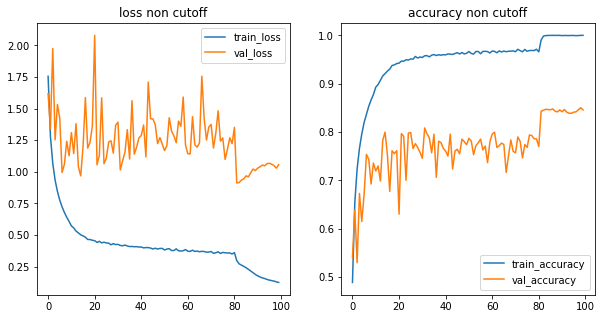

In [89]:
epoch_vis = list(range(100))
train_loss_noncutoff = history_nocutoff.history['loss']
train_auc_noncutoff = history_nocutoff.history['acc']
test_loss_noncutoff = history_nocutoff.history['val_loss']
test_auc_noncutoff = history_nocutoff.history['val_acc']
fig, ax = plt.subplots(1,2,figsize = (10,5))
ax[0].plot(epoch_vis, train_loss_noncutoff, label = 'train_loss')
ax[1].plot(epoch_vis, train_auc_noncutoff, label = 'train_accuracy')
ax[0].plot(epoch_vis, test_loss_noncutoff, label = 'val_loss')
ax[1].plot(epoch_vis, test_auc_noncutoff, label = 'val_accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_title('loss non cutoff')
ax[1].set_title('accuracy non cutoff')

### $\color{purple}{\text{question 3}}$
Next use cutout for data augmentation in Resnet-44 as in Hoffer et al. and train the model and use the same set-up in your experiments. Plot validation error vs number of epochs for different values of M (2,4,8,16) where M is the number of instances generated from an input sample after applying cutout M times effectively increasing the batch size to M ·B, where B is the original batch size (before applying cutout augmentation). You will obtain a figure similar to Figure 3(a) in the paper by Hoffer et al. Also compare the number of epochs and wallclock time to reach 92% accuracy for different values of M. Do not run any experiment for more than 100 epochs. If even after 100 epochs of training you did not achieve 92% then just report the accuracy you obtain and the corresponding wallclock time to train for 100 epochs. Remember to use the same hyperparameters for training as used with Resnet44 training in He et al (look at the third paragraph in Sec. 4.2 of He et al for the hyperparameter values). Before attempting this question it is advisable to read the paper by Hoffer et al. and especially Section 4.1. 

In [4]:
def cut_off_train_data(M):
    train_x_cutoff = []
    train_y_cutoff = []
    for index, img in enumerate(X_train):
        for m in range(M):
            train_x_cutoff.append(apply_mask(img.copy()))
            train_y_cutoff.append(y_train[index])
    return np.array(train_x_cutoff),np.array(train_y_cutoff)

def train_a_cut_off_model(M):
    # def model 
    model_cutoff = resnet_v1(input_shape=input_shape, depth=depth)
    model_cutoff.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(lr=lr_schedule(0)),
                  metrics=['acc'])
    # training_data
    train_with_m_x, train_with_m_y = cut_off_train_data(M)
    
    
    # trainmodel
    lr_scheduler = LearningRateScheduler(lr_schedule)

    lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                                   cooldown=0,
                                   patience=5,
                                   min_lr=0.5e-6)
    callbacks = [lr_reducer, lr_scheduler]

    start_time = time.time()
    history_cutoff = model_cutoff.fit(train_with_m_x, train_with_m_y,
                  batch_size=32*M,
                  epochs=20,
                  validation_data=(X_test, y_test),
                  shuffle=True,
                  callbacks=callbacks)
    end_time = time.time()
    
    total_time = end_time - start_time
    
    return history_cutoff, total_time


In [16]:
history_cutoff_1, time_1 = train_a_cut_off_model(1)

Epoch 1/20
1563/1563 [==============================] - 42s 24ms/step - loss: 1.8269 - acc: 0.4535 - val_loss: 1.7007 - val_acc: 0.5169 - lr: 0.0010
Epoch 2/20
1563/1563 [==============================] - 35s 22ms/step - loss: 1.3741 - acc: 0.6112 - val_loss: 1.2922 - val_acc: 0.6451 - lr: 0.0010
Epoch 3/20
1563/1563 [==============================] - 37s 24ms/step - loss: 1.1725 - acc: 0.6821 - val_loss: 1.3092 - val_acc: 0.6473 - lr: 0.0010
Epoch 4/20
1563/1563 [==============================] - 37s 24ms/step - loss: 1.0547 - acc: 0.7220 - val_loss: 1.2850 - val_acc: 0.6672 - lr: 0.0010
Epoch 5/20
1563/1563 [==============================] - 37s 24ms/step - loss: 0.9668 - acc: 0.7533 - val_loss: 1.1702 - val_acc: 0.7001 - lr: 0.0010
Epoch 6/20
1563/1563 [==============================] - 45s 29ms/step - loss: 0.9028 - acc: 0.7760 - val_loss: 1.0027 - val_acc: 0.7463 - lr: 0.0010
Epoch 7/20
1563/1563 [==============================] - 41s 26ms/step - loss: 0.8560 - acc: 0.7933 - val_l

In [17]:
history_cutoff_2, time_2 = train_a_cut_off_model(2)

Epoch 1/20
1563/1563 [==============================] - 48s 28ms/step - loss: 1.6457 - acc: 0.5184 - val_loss: 1.5763 - val_acc: 0.5705 - lr: 0.0010
Epoch 2/20
1563/1563 [==============================] - 49s 32ms/step - loss: 1.1203 - acc: 0.6999 - val_loss: 1.0923 - val_acc: 0.7161 - lr: 0.0010
Epoch 3/20
1563/1563 [==============================] - 51s 33ms/step - loss: 0.9183 - acc: 0.7664 - val_loss: 0.9938 - val_acc: 0.7513 - lr: 0.0010
Epoch 4/20
1563/1563 [==============================] - 50s 32ms/step - loss: 0.8104 - acc: 0.8026 - val_loss: 0.9377 - val_acc: 0.7559 - lr: 0.0010
Epoch 5/20
1563/1563 [==============================] - 51s 33ms/step - loss: 0.7362 - acc: 0.8278 - val_loss: 1.0307 - val_acc: 0.7403 - lr: 0.0010
Epoch 6/20
1563/1563 [==============================] - 51s 33ms/step - loss: 0.6810 - acc: 0.8489 - val_loss: 1.2214 - val_acc: 0.7131 - lr: 0.0010
Epoch 7/20
1563/1563 [==============================] - 51s 33ms/step - loss: 0.6371 - acc: 0.8660 - val_l

In [18]:
history_cutoff_4, time_4 = train_a_cut_off_model(4)

Epoch 1/20
1563/1563 [==============================] - 75s 45ms/step - loss: 1.4920 - acc: 0.5760 - val_loss: 1.4764 - val_acc: 0.5846 - lr: 0.0010
Epoch 2/20
1563/1563 [==============================] - 71s 45ms/step - loss: 0.9425 - acc: 0.7595 - val_loss: 1.0704 - val_acc: 0.7329 - lr: 0.0010
Epoch 3/20
1563/1563 [==============================] - 70s 45ms/step - loss: 0.7437 - acc: 0.8248 - val_loss: 1.1984 - val_acc: 0.7157 - lr: 0.0010
Epoch 4/20
1563/1563 [==============================] - 70s 45ms/step - loss: 0.6328 - acc: 0.8642 - val_loss: 1.0041 - val_acc: 0.7695 - lr: 0.0010
Epoch 5/20
1563/1563 [==============================] - 69s 44ms/step - loss: 0.5617 - acc: 0.8907 - val_loss: 1.1104 - val_acc: 0.7634 - lr: 0.0010
Epoch 6/20
1563/1563 [==============================] - 70s 45ms/step - loss: 0.5148 - acc: 0.9089 - val_loss: 1.2633 - val_acc: 0.7558 - lr: 0.0010
Epoch 7/20
1563/1563 [==============================] - 70s 45ms/step - loss: 0.4854 - acc: 0.9222 - val_l

In [19]:
history_cutoff_8, time_8 = train_a_cut_off_model(8)

Epoch 1/20
1563/1563 [==============================] - 111s 67ms/step - loss: 1.3337 - acc: 0.6264 - val_loss: 1.3204 - val_acc: 0.6608 - lr: 0.0010
Epoch 2/20
1563/1563 [==============================] - 105s 67ms/step - loss: 0.7546 - acc: 0.8194 - val_loss: 1.2154 - val_acc: 0.7099 - lr: 0.0010
Epoch 3/20
1563/1563 [==============================] - 116s 74ms/step - loss: 0.5650 - acc: 0.8839 - val_loss: 1.0629 - val_acc: 0.7585 - lr: 0.0010
Epoch 4/20
1563/1563 [==============================] - 122s 78ms/step - loss: 0.4715 - acc: 0.9172 - val_loss: 0.9881 - val_acc: 0.7836 - lr: 0.0010
Epoch 5/20
1563/1563 [==============================] - 123s 78ms/step - loss: 0.4210 - acc: 0.9356 - val_loss: 1.2083 - val_acc: 0.7541 - lr: 0.0010
Epoch 6/20
1563/1563 [==============================] - 123s 79ms/step - loss: 0.3939 - acc: 0.9455 - val_loss: 2.0251 - val_acc: 0.6670 - lr: 0.0010
Epoch 7/20
1563/1563 [==============================] - 119s 76ms/step - loss: 0.3745 - acc: 0.9518 

In [7]:
history_cutoff_16, time_16 = train_a_cut_off_model(16)

Epoch 1/20
1563/1563 [==============================] - 191s 117ms/step - loss: 1.1494 - acc: 0.6959 - val_loss: 1.6258 - val_acc: 0.6408 - lr: 0.0010
Epoch 2/20
1563/1563 [==============================] - 182s 117ms/step - loss: 0.5523 - acc: 0.8954 - val_loss: 1.3549 - val_acc: 0.7339 - lr: 0.0010
Epoch 3/20
1563/1563 [==============================] - 183s 117ms/step - loss: 0.4096 - acc: 0.9425 - val_loss: 1.4744 - val_acc: 0.7359 - lr: 0.0010
Epoch 4/20
1563/1563 [==============================] - 182s 117ms/step - loss: 0.3614 - acc: 0.9563 - val_loss: 2.2739 - val_acc: 0.6582 - lr: 0.0010
Epoch 5/20
1563/1563 [==============================] - 182s 116ms/step - loss: 0.3370 - acc: 0.9627 - val_loss: 1.7049 - val_acc: 0.7021 - lr: 0.0010
Epoch 6/20
1563/1563 [==============================] - 180s 115ms/step - loss: 0.3196 - acc: 0.9661 - val_loss: 1.8806 - val_acc: 0.7054 - lr: 0.0010
Epoch 7/20
1563/1563 [==============================] - 181s 116ms/step - loss: 0.3065 - acc: 

In [8]:
import pickle
#history_list = [history_cutoff_1.history,history_cutoff_2.history,history_cutoff_4.history,history_cutoff_8.history]
#time_list = [time_1,time_2,time_4,time_8] 
#
#with open('Q4_trained_data.pkl','wb') as handle:
#    pickle.dump((history_list,time_list),handle ,protocol = pickle.HIGHEST_PROTOCOL)

with open('Q4_trained_data.pkl','rb') as handle:
    previous_result = pickle.load(handle)

In [14]:
history_list_final = [previous_result[0][0], previous_result[0][1], previous_result[0][2],
                      previous_result[0][3], history_cutoff_16.history]
time_list_final = [previous_result[1][0],previous_result[1][1],previous_result[1][2],previous_result[1][3], time_16] 
with open('Q4_final_result_data.pkl','wb') as handle:
    pickle.dump((history_list_final,time_list_final),handle ,protocol = pickle.HIGHEST_PROTOCOL)

In [15]:
with open('Q4_final_result_data.pkl','rb') as handle:
    final_result = pickle.load(handle)

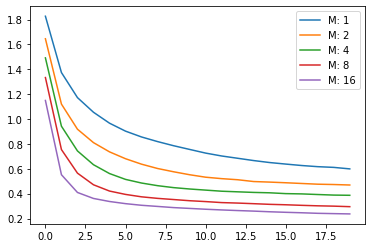

In [29]:
for i in range(5):
    epoch_vis = list(range(20))
    plt.plot(epoch_vis,final_result[0][i]['loss'], label = 'M: '+str(2**i))
plt.legend()

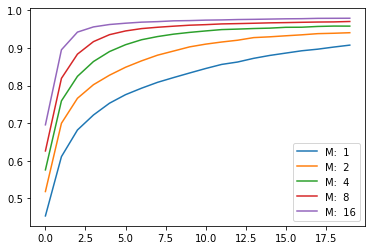

In [31]:
for i in range(5):
    epoch_vis = list(range(20))
    plt.plot(epoch_vis,final_result[0][i]['acc'], label = 'M:  ' +str(2**i))
plt.legend()

In [32]:
# training_time
final_result[1]

[815.8369281291962,
 1008.5819070339203,
 1361.3079934120178,
 2330.293242454529,
 3645.6672925949097]

- due to time limitation, I only ran 20 epochs here